In [50]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 14 23:26:14 2022

@author: Mousumi
"""

import math
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.integrate import odeint
#from numpy import random
#import time
# %matplotlib qt5

import matplotlib.pyplot as plt
from matplotlib import ticker


# from model1 import x_data
# x_data=np.transpose(x_data)

#----------------------------------------------------------------------------------------------------
def model(states,t,eps):

    x=states[0]
    y=states[1]
    z=states[2]
    s=states[3]
            
    dx = np.zeros(states.shape)
    alpha=-0.02
    b=0.15
    k=1
    
    dx[0] = y
    dx[1] = z
    dx[2] = -y+3*y**2-x**2-x*z+alpha+eps*s
    dx[3] = -k*s-eps*(z-b)
    
    return dx

#-----------------------------------------------------------------------------------------------------
def solve_model(epsilon,x_in,y_in):
    time=200000
    ntrans=100000
    x_data=np.zeros((time-ntrans,dim*len(epsilon)))

    xy_init = np.array([0,0,0,0.1])
    xy_init[:2] = [x_in,y_in]

    t = np.linspace(0,time*0.01,time)
    statess = np.zeros((len(t),len(epsilon)*dim))

    for ii in range(len(epsilon)):
        statess=odeint(model, xy_init, t, args=(epsilon[ii],)) 
        x_data[:,ii*(dim):(ii+1)*(dim)]=statess[ntrans:,:]
        
    return x_data

#--------------------------------------------------------------------------------------------------------    
def W_inn(n,dim,W_in_a):
    W_inputt = np.zeros((n, dim+1))
    rnd0 = np.random.RandomState(0)
    rnd1 = np.random.RandomState(1)
    for i in range(n):
        W_inputt[i, math.floor(i*dim/n)] = (2*rnd0.random()-1)*W_in_a

    W_inputt[:, dim] = (2*rnd1.random((n))-1)*W_in_a
    return W_inputt

#-------------------------------------------------------------------------------------------------------
def W_ress(k,n,eig_rho):
    # # ER network n*n and its radius is eig_rho
    prob = k/(n-1)
    # set the seeds
    rnd0 = np.random.RandomState(3)  # connection rng
    rnd1 = np.random.RandomState(4)  # sampling rng
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            b = rnd0.random()
            if (i != j) and (b < prob):
                W[i, j] = rnd1.random()

    rad = max(abs(LA.eigvals(W)))
    W_reservoirr = W*(eig_rho/rad)  

    return W_reservoirr

#--------------------------------------------------------------------------------------------------------
# ESN dynamics

def create_ESN(ESN_par,x_data,par1,W_in,W_res):
    n=ESN_par[0]
    alpha=ESN_par[1]
    beta=ESN_par[2]
    Nt=ESN_par[3]
    Np=ESN_par[4]
    transit=ESN_par[5]
    dim=ESN_par[6]
    tp_dim=len(par1)
    

# training phase

    U = np.zeros((dim, tp_dim*(Nt-transit+1)))  
    R = np.zeros((n, tp_dim*(Nt-transit+1)))  
    #m = np.random.randint(0, 2000)
    m = 1
    for ii in range(tp_dim):
        print(par1[ii])
        u_train = x_data[dim*ii:dim*(ii+1), (m-1):(m+Nt)]
        u1_train = np.vstack((u_train, par1[ii]*np.ones((1, Nt+1))))
        
        r1 = np.zeros((n, Nt+1))
        r2 = np.zeros((n, Nt+1))

        for i in range(Nt):
            
            r1[:, i+1] = (1-alpha)*r1[:, i]+alpha *np.tanh(np.dot(W_res, r1[:, i])+np.dot(W_in, u1_train[:, i]))
            r2[:, i+1] = r1[:, i+1]
            r2[1::2, i+1] = r1[1::2, i+1]**2

        U[:, (Nt-transit+1)*ii:(Nt-transit+1)*(ii+1)] = u1_train[:dim, transit:(Nt+1)]
        R[:, (Nt-transit+1)*ii:(Nt-transit+1)*(ii+1)] = r2[:, transit:(Nt+1)]
        print(u1_train[:dim, transit])
        print(u1_train[:dim, Nt])
        #print(r2[:100, transit])
        #print(r2[:100, Nt])

    R_T = np.transpose(R)
    W_out = np.dot(np.dot(U, R_T), np.linalg.inv((np.dot(R, R_T)+beta*np.identity(n))))
    
    return W_out


In [4]:
#------------------------------------------------------------------------------------------------------
# predicting phase to check the efficiency of the machine
# this part is only for optimizing the parameter. 


def error_cal(train_par,x_data,W_out,W_res,W_in):
    rmse_mean=np.zeros(len(train_par))
    mm = np.random.randint(0, 3000)+60000
    for j in range(len(train_par)):
        u_train = x_data[dim*j:dim*(j+1), mm:mm+Np]
        u_predict = np.vstack((u_train, train_par[j]*np.ones((1, Np))))
        
        r3 = np.zeros((n, Np))
        r4 = np.zeros((n))
        for i in range(Np-1):
            r3[:, i+1] = (1-alpha)*r3[:, i]+alpha*np.tanh(np.dot(W_res,r3[:, i])+np.dot(W_in, u_predict[:, i]))
            r4[:] = r3[:, i+1]
            r4[1::2] = r3[1::2, i+1]**2
            if i >= 100:
                u_predict[:dim, i+1] = np.dot(W_out, r4)
        plt.figure(figsize=(12,4))
        plt.plot(u_train[0,:])
        plt.plot(u_predict[0,:],'--')
        rmse_total = u_train[:dim, :Np]-u_predict[:dim, :Np]
        rmse_mean[j] = np.sqrt(np.mean(rmse_total**2))
    
    return np.mean(rmse_mean)


In [55]:

#-------------------------------------------------------------------------------------------
#prediction for new parameter 
def prediction(n,par,x_initial,y_initial,W_out,W_res,W_in):      
    
    pred_time=60000
    # u_train = np.zeros((4,pred_time))
    u_train = x_initial*np.ones((1, pred_time))
    u_train = np.vstack((u_train, y_initial*np.ones((1, pred_time))))
    u_train = np.vstack((u_train, 0*np.ones((1, pred_time))))
    u_train = np.vstack((u_train, 0.1*np.ones((1, pred_time))))

    u_predict = np.vstack((u_train, par*np.ones((1, pred_time))))

    r3 = np.zeros((n, pred_time))
    r4 = np.zeros((n))
    
    for i in range(pred_time-1):
        r3[:, i+1] = (1-alpha)*r3[:, i]+alpha*np.tanh(np.dot(W_res,r3[:, i])+np.dot(W_in, u_predict[:, i]))
        r4[:] = r3[:, i+1]
        r4[1::2] = r3[1::2, i+1]**2
        
        if i >= 500:
            u_predict[:dim, i+1] = np.dot(W_out, r4)

    pred_data = u_predict[:, 10000:]

    return pred_data


#----------------------------------------------------------------------------------------------------
# original system data genertation

train_par1=np.array([0.36,0.38,0.40])

dim=4
x_in=4
y_in=0
x_data=np.transpose(solve_model(train_par1,x_in,y_in))
print('original dynamics generated')
#--------------------------------------------------------------------------------------------------

original dynamics generated


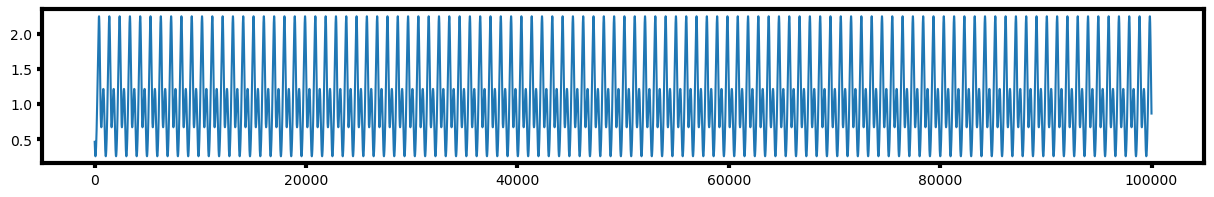

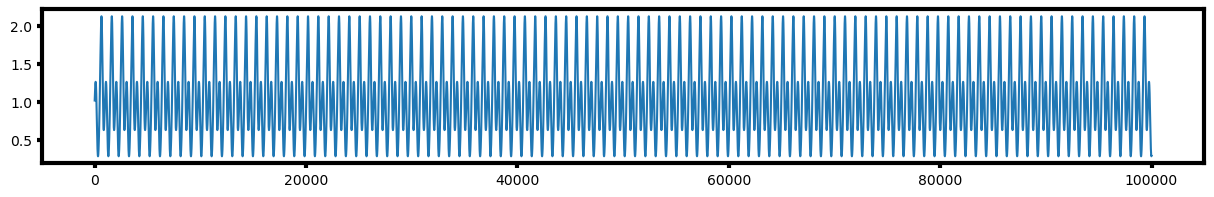

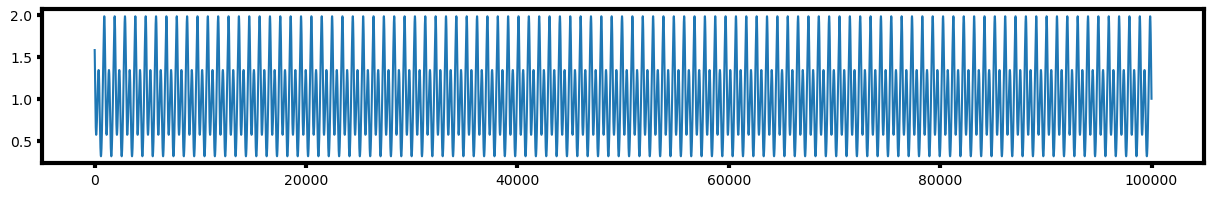

In [15]:
plt.figure(figsize = (15,2))
plt.plot(x_data[0,:])
plt.figure(figsize = (15,2))
plt.plot(x_data[4,:])
plt.figure(figsize = (15,2))
plt.plot(x_data[8,:])

In [35]:
# ####ESN parameter  making ESN

beta = 5e-8 
W_in_a = 0.06
alpha = 0.385
eig_rho = 0.5057


Nt = 60000  # training length
Np = 400    # predicting length
wa = 100  # warmup length
transit = 51  # abondon reservoir length
n = 1200  # reservoir size
k =20

ESN_par=[n,alpha,beta,Nt,Np,transit,dim]

W_input=W_inn(n,dim,W_in_a)

W_reservoir= W_ress(k,n,eig_rho)
print('ESN built')


ESN built


In [53]:
print('Training started')
W_out=create_ESN(ESN_par,x_data,train_par1,W_input,W_reservoir)
print('Training done')

Training started
0.36
[ 0.27991581 -0.16814719  0.80609337 -0.02329645]
[ 1.14572289 -1.07608562  0.95796293  0.24409173]
0.38
[ 1.21027657  0.26999402 -0.5587989   0.03595417]
[ 0.48437553  0.47967423  0.46999614 -0.12404955]
0.4
[ 1.03707116 -0.99683011  0.7301181   0.26750101]
[ 0.82516381  0.47725966  0.20131783 -0.13078799]
Training done


In [54]:
W_out

array([[ 0.16379261,  0.12167215,  0.25784302, ..., -0.01064587,
        -0.00408554, -0.00851035],
       [-0.00621903, -0.00891251,  0.01101957, ...,  0.01351623,
        -0.0191927 , -0.00759064],
       [-0.0528509 , -0.42674422,  0.13924026, ...,  0.04718457,
        -0.03781128, -0.03594486],
       [ 0.00961363, -0.00759262,  0.01400137, ..., -0.00353168,
        -0.27975774, -0.00839964]])

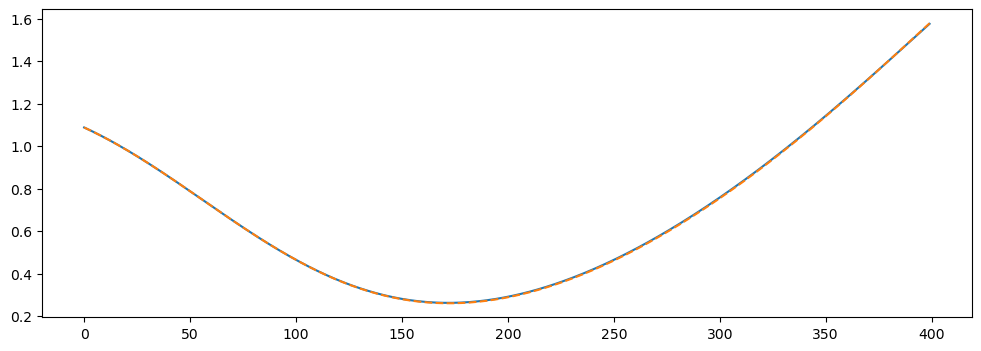

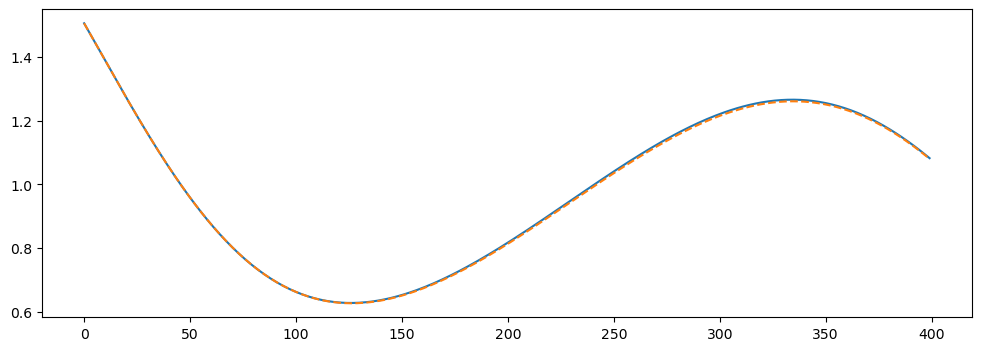

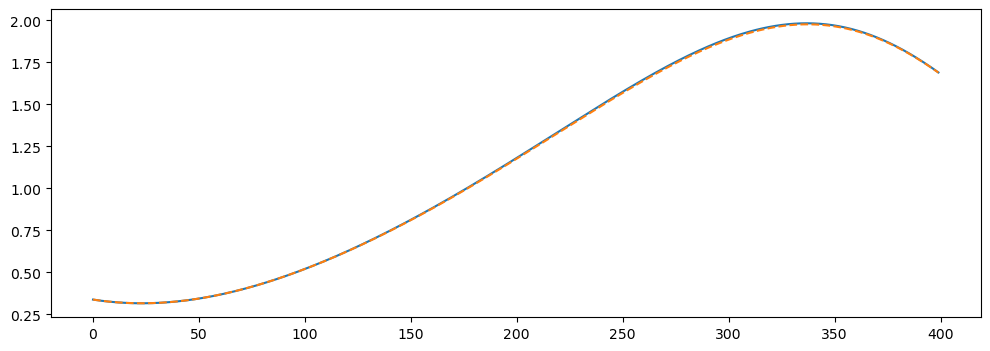

In [15]:
error=error_cal(train_par1,x_data,W_out,W_reservoir,W_input) 

In [16]:
error

0.005761927277438381

In [57]:

# #--------prediction for a new parameter--------------------------------------------------------------------

x_inittt = [4]  
y_inittt = [0]  

par = np.arange(0,0.7,0.02)     # new parameter


local_maxx=np.zeros((len(par),200))
print('prediction strated')
for ind_par in range(len(par)):
    
    print(par[ind_par])
    pred_data = prediction(n, par[ind_par], x_inittt, y_inittt, W_out, W_reservoir, W_input)[0]
    aa = []
    for ind_pred_data in range(len(pred_data)-2):
            
        if pred_data[ind_pred_data+2]-pred_data[ind_pred_data+1] < 0 and pred_data[ind_pred_data+1]-pred_data[ind_pred_data] > 0:
            aa = np.append(aa, pred_data[ind_pred_data+1])
            
    if pred_data[-2]-pred_data[-3] < 10**-3:
        aa = np.append(aa,pred_data[-2])
                    
            
    for ind_aa in range(len(aa)):
        local_maxx[ind_par,ind_aa] = aa[ind_aa] 
        


prediction strated
0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68


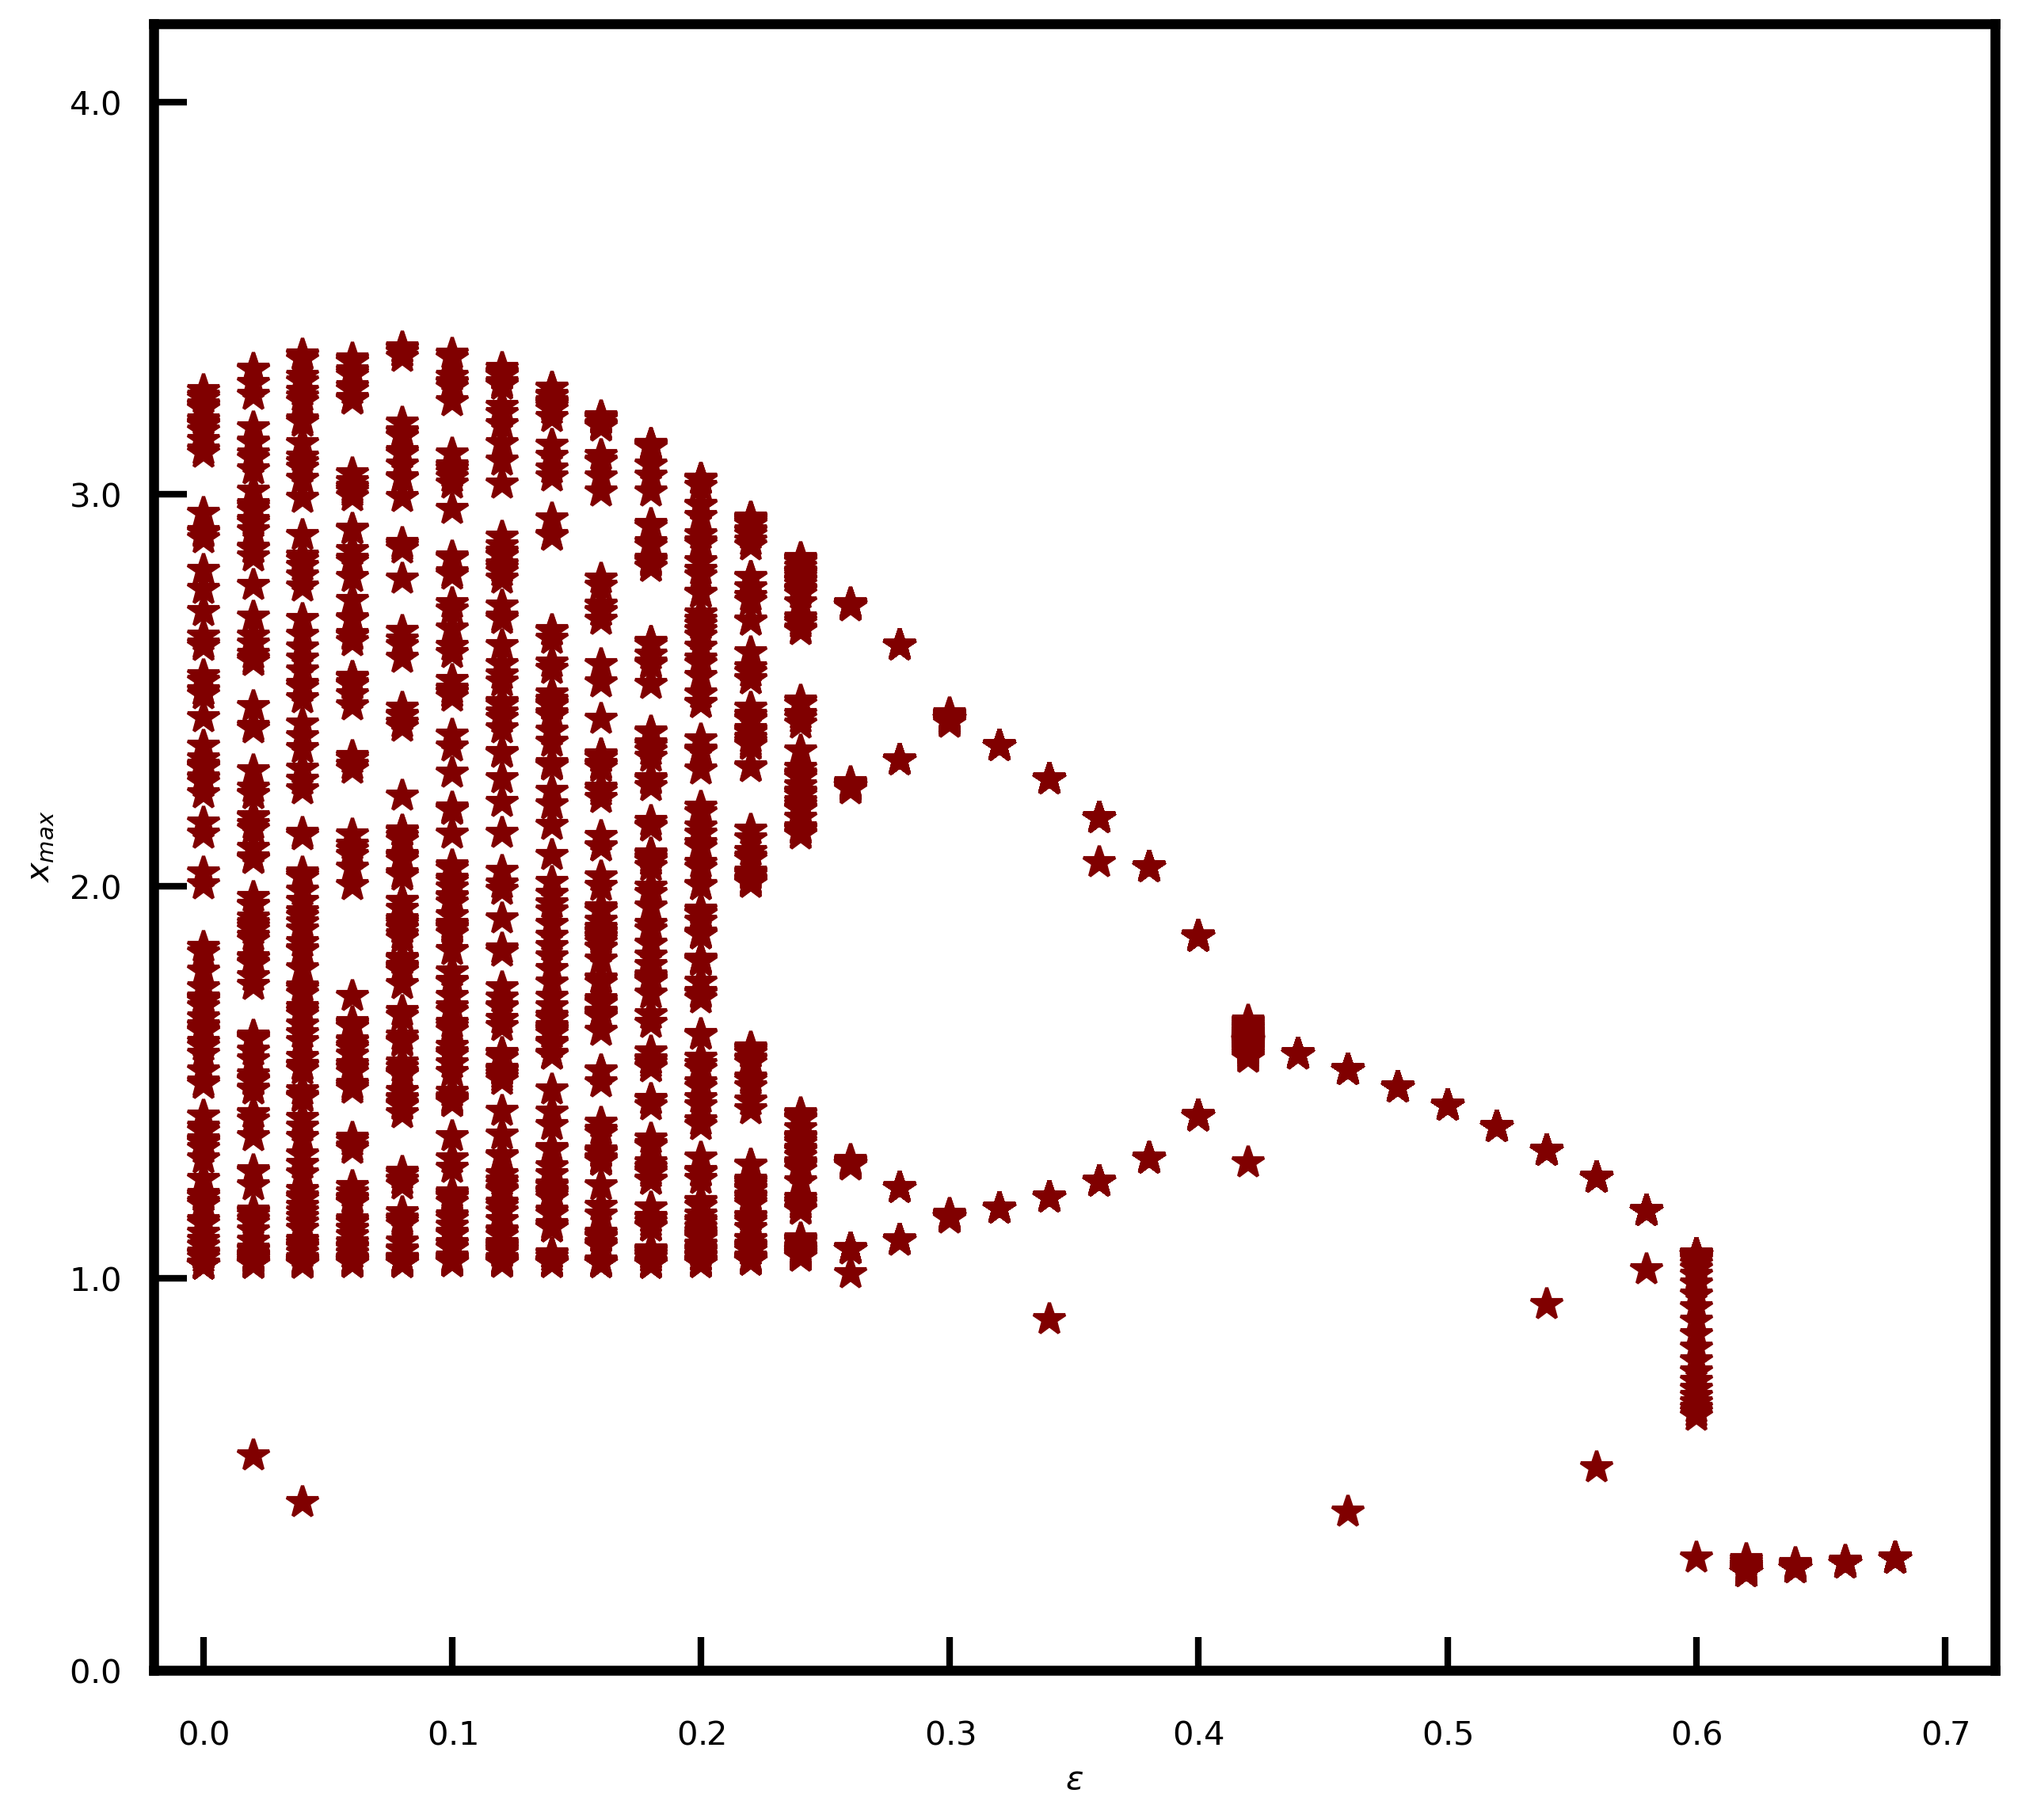

In [58]:
fig, ax = plt.subplots(figsize=(10, 9), dpi=300)

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['axes.linewidth'] = 3

for ind_par in range(len(par)):
 
    plot_local_maxx=local_maxx[ind_par,np.where(local_maxx[ind_par,:]!=0)]  
    ax.plot(par[ind_par]*np.ones(len(plot_local_maxx)), plot_local_maxx, color='maroon', marker='*', linestyle='None',
                                        linewidth=3, markersize=10)
    

ax.set_xticks([0,.1,.2,.3,.4,.5,.6,.7])
ax.set_xticklabels([r'$0.0$',r'$0.1$', r'$0.2$',
                        r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$'])

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels([r'$0.0$',r'$1.0$', r'$2.0$',
                        r'$3.0$',r'$4.0$'])

ax.tick_params( direction='in', length=20,width=8,pad=16)
    
ax.set_xlim([-0.02,0.72])
ax.set_ylim([0,4.2])
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$x_{max}$')
ax.tick_params(axis="x", direction='in', length=10, width=2, pad=15)
ax.tick_params(axis="y", direction='in', length=10, width=2, pad=10)

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5


C:\Users\egeoz\AppData\Local\Temp\ipykernel_13004\730167801.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,4), constrained_layout = True)


0.55
0.6000000000000001
0.65
0.7000000000000001


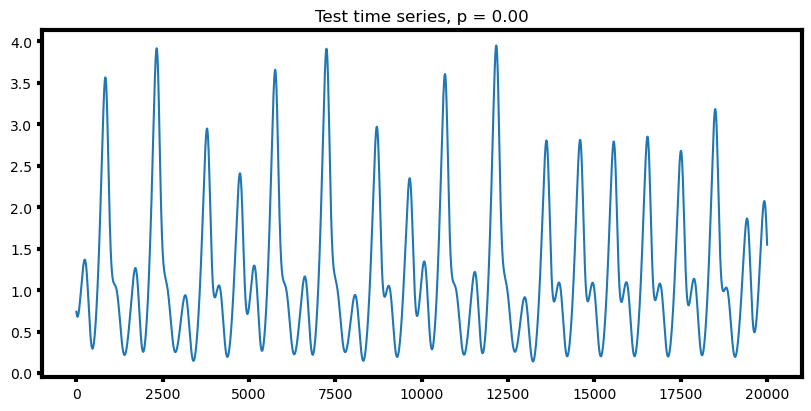

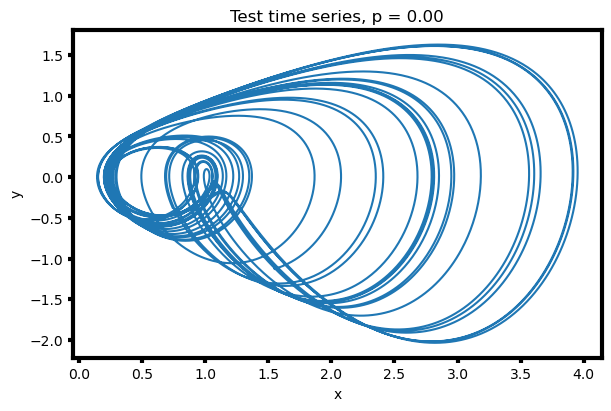

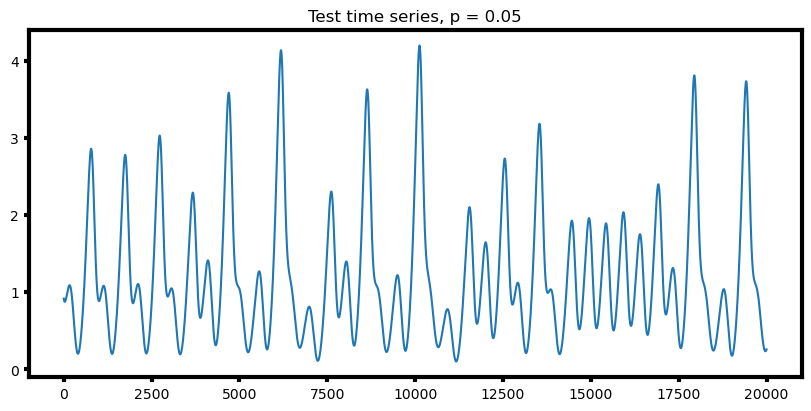

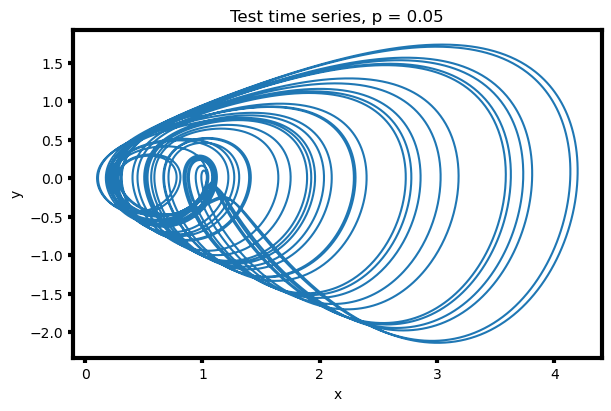

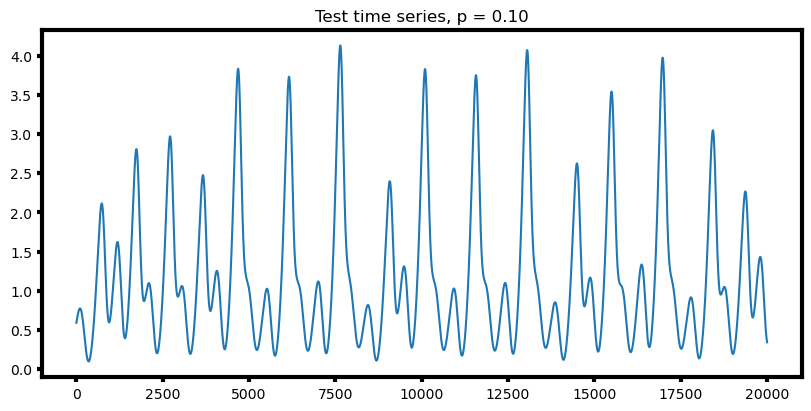

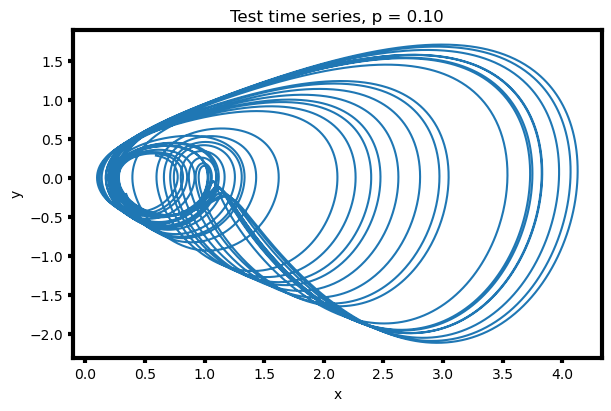

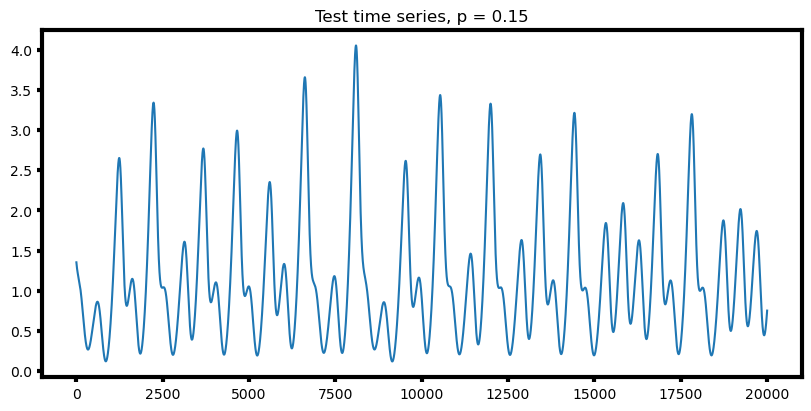

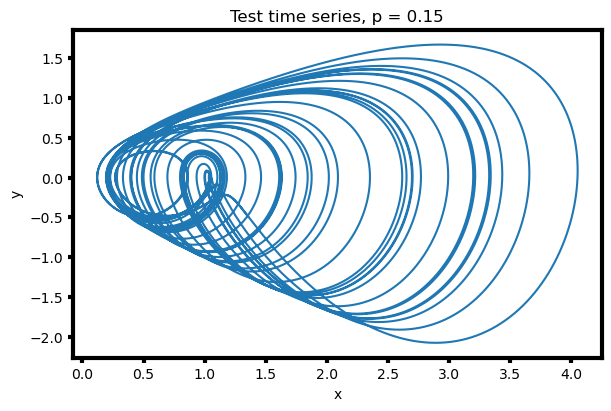

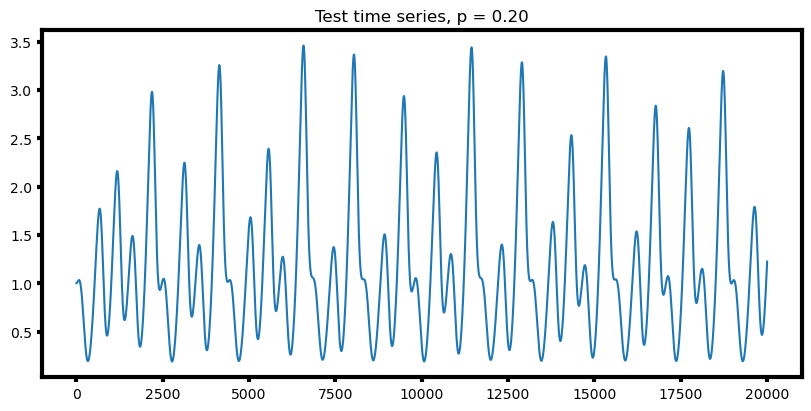

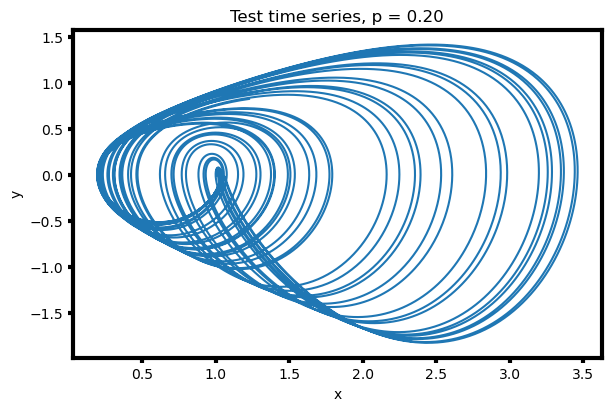

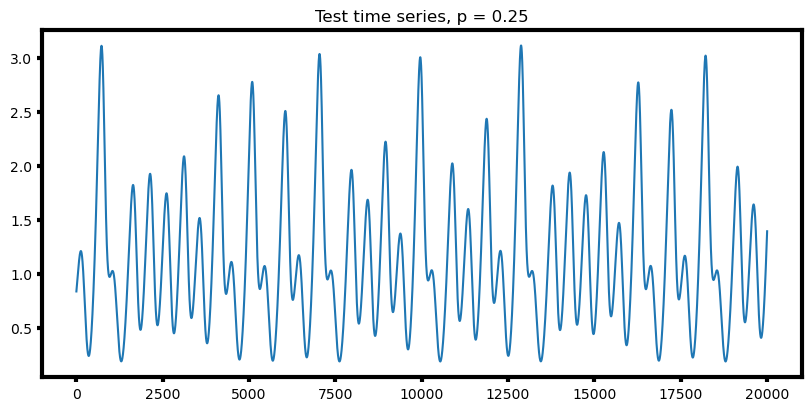

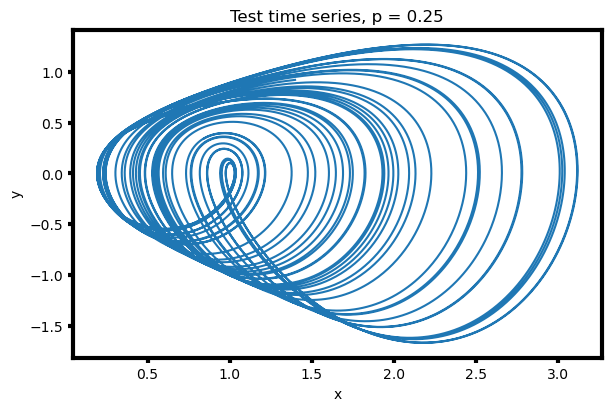

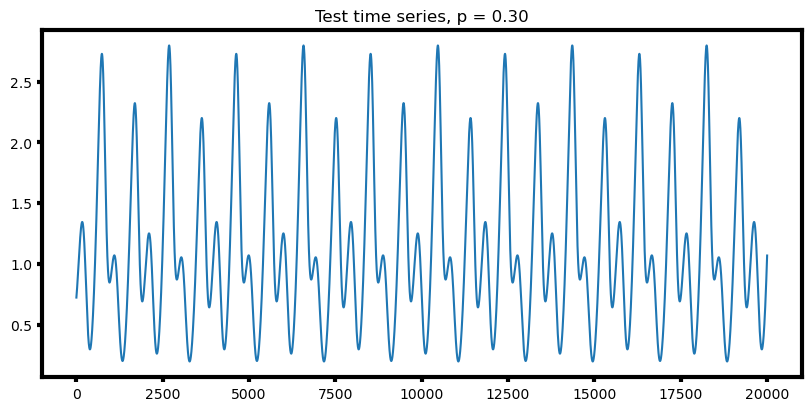

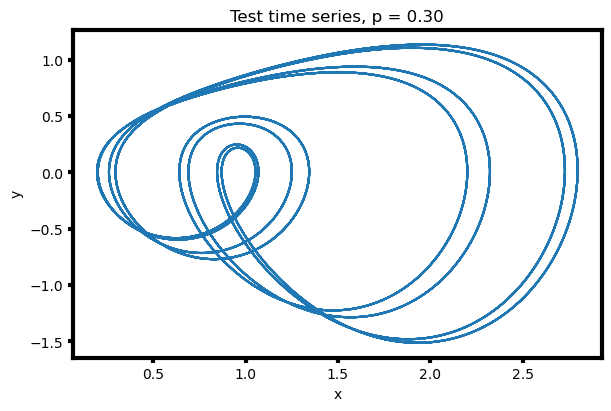

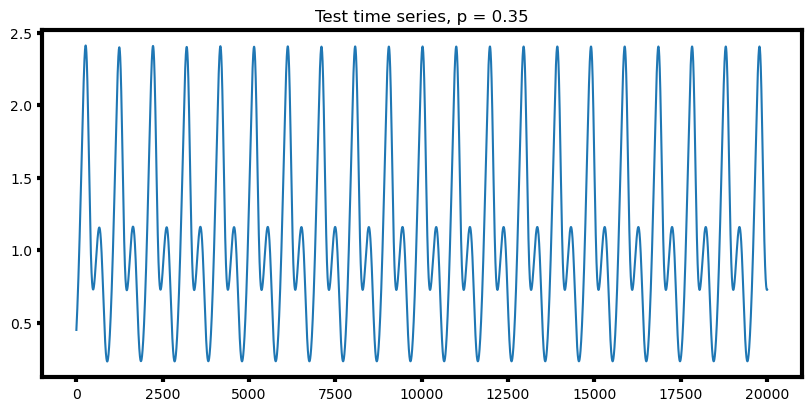

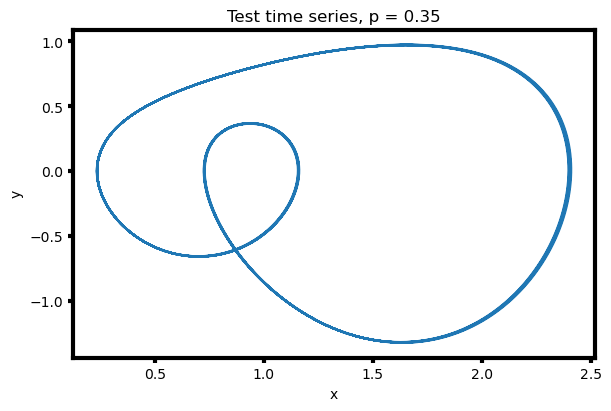

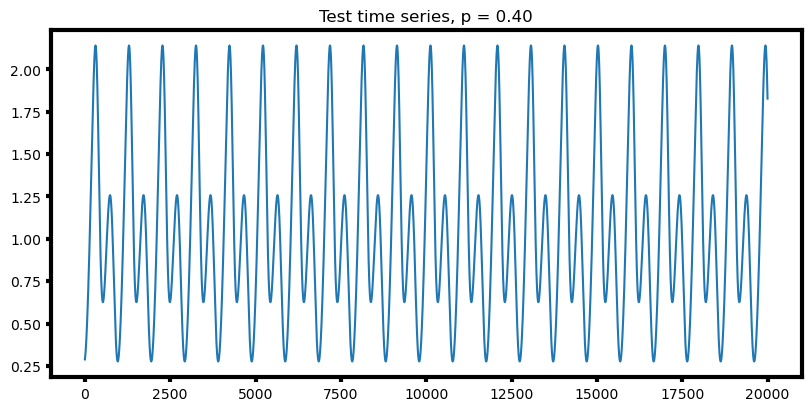

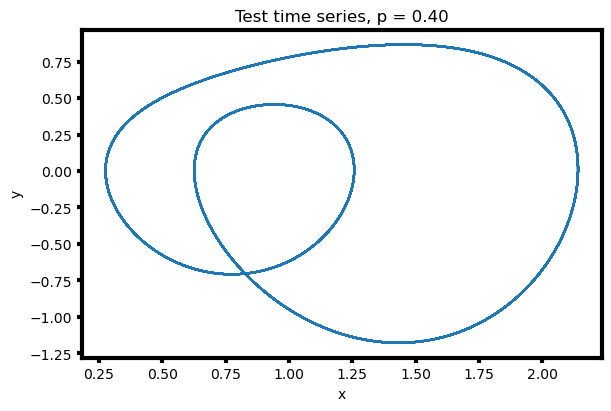

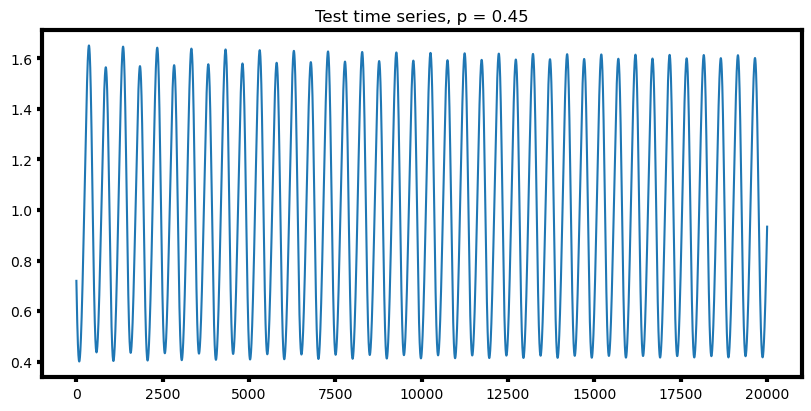

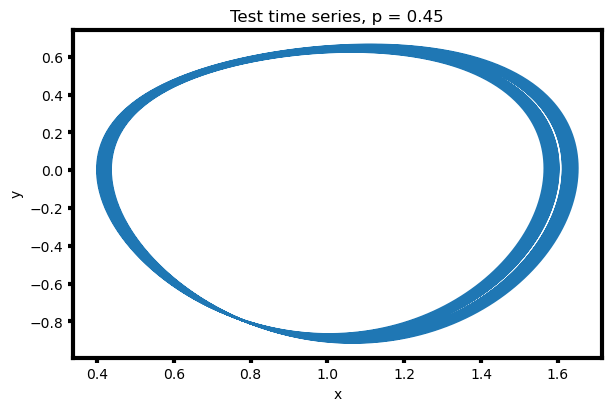

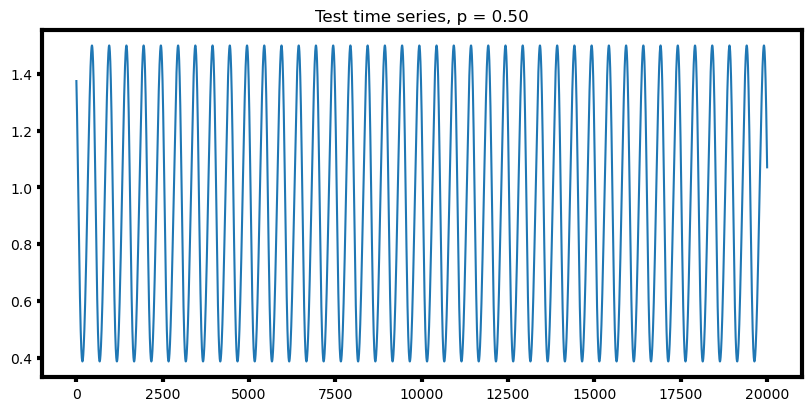

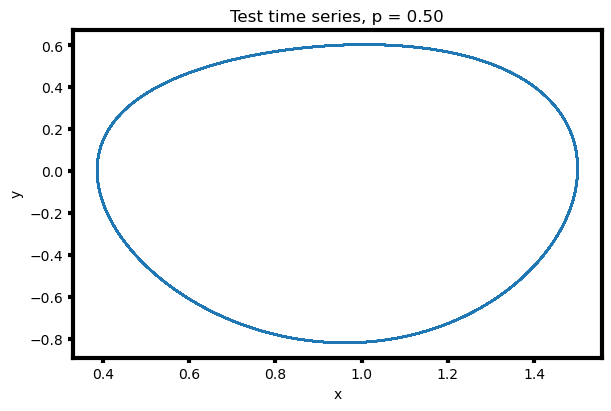

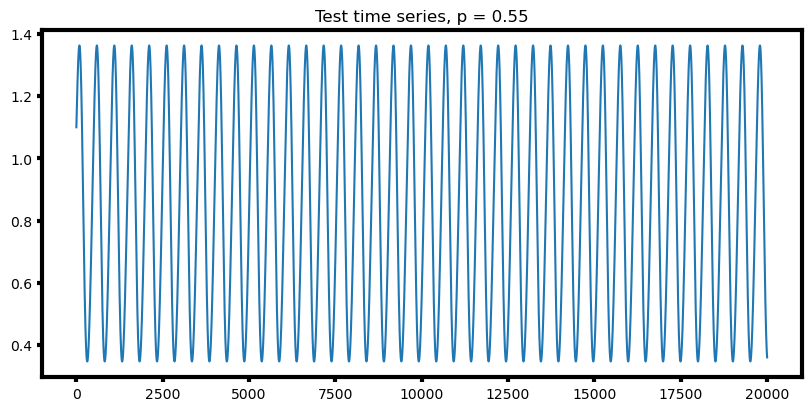

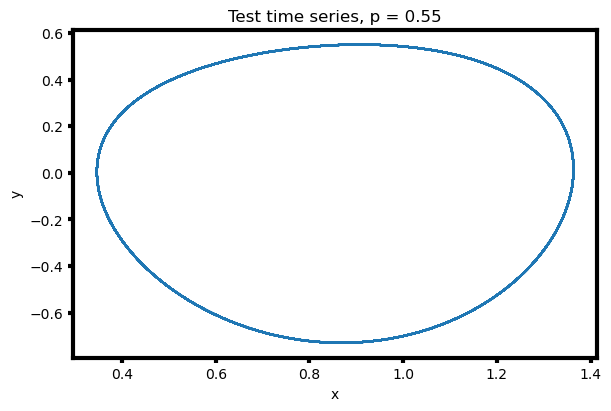

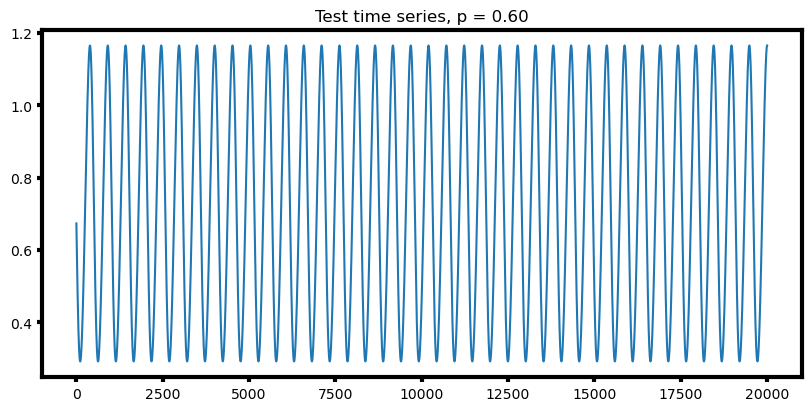

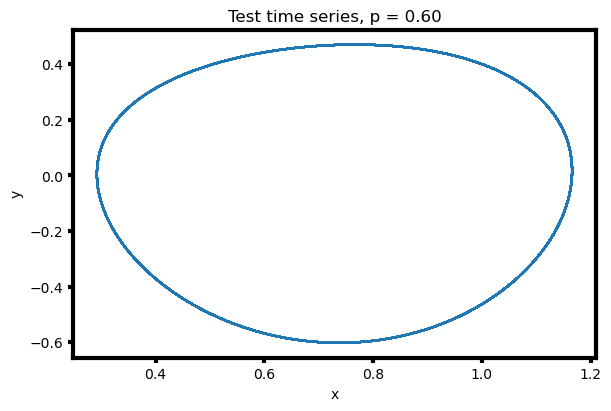

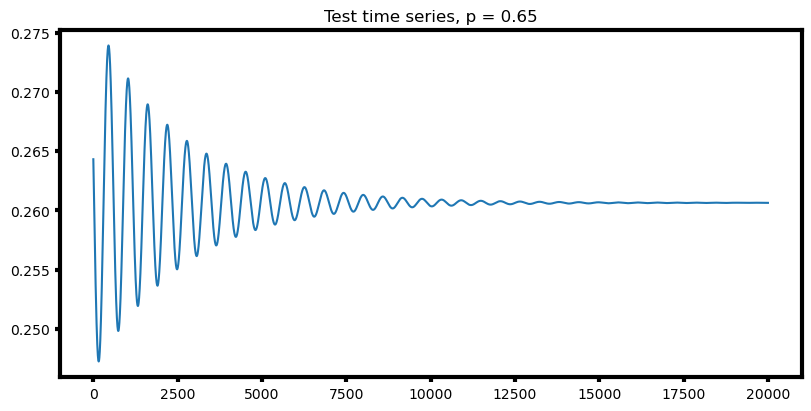

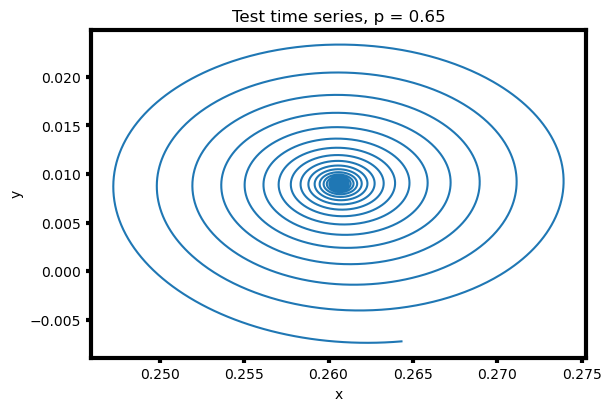

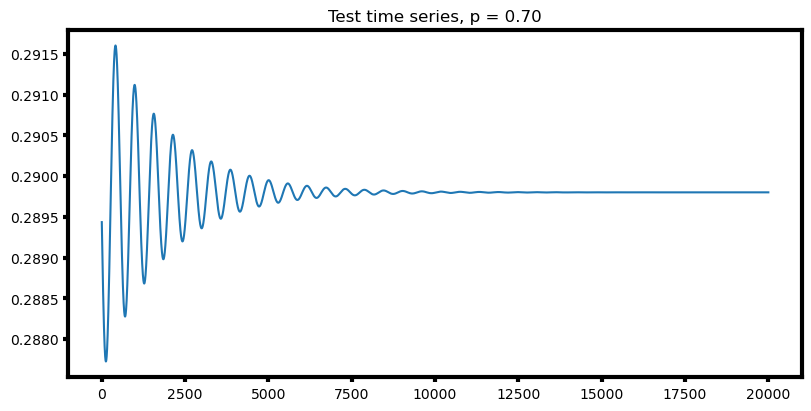

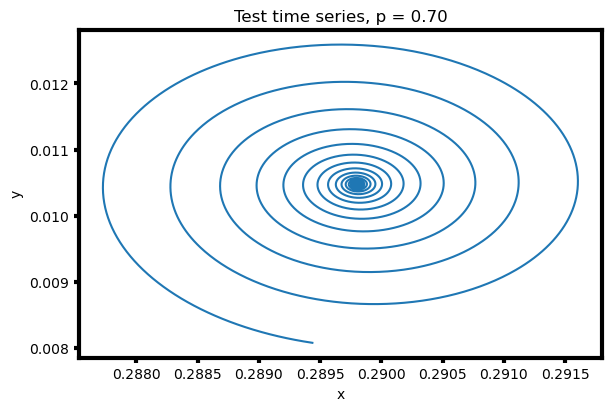

In [23]:
par = np.arange(0,0.75,0.05)     # new parameter
for ind_par in range(len(par)):
    
    print(par[ind_par])
    pred_data = prediction(n, par[ind_par], x_inittt, y_inittt, W_out, W_reservoir, W_input)
    
    plt.figure(figsize=(8,4), constrained_layout = True)
    plt.plot(pred_data[0])
    plt.title(f"Test time series, p = {par[ind_par]:4.2f}")

    plt.figure(figsize=(6,4), constrained_layout = True)
    plt.plot(pred_data[0],pred_data[1])
    plt.title(f"Test time series, p = {par[ind_par]:4.2f}")
    plt.xlabel("x")
    plt.ylabel(f"y")